# VaR Computations

Given a **PDF** $F(\textbf{X})$ and a confidence level $\alpha$, the corresponding **Value at Risk**, $VaR_\alpha(\textbf{X})$, can be defined as the smallest $\tilde{\textbf{x}}$ such that:

$$F[\textbf{X} \leq \tilde{\textbf{x}}]\geq (1-\alpha).$$


Once the **PQC**, which we use as a surrogate model of complex and time-consuming financial distribution $F(\textbf{X})$, is trained, It can be used for perform easily **VaR** computations by evaluating it in different domain points. 

The present notebook explains how to perform this computations.

In [ ]:
import json
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../../")

## 1. Load the Data

First the complete training and testing data will be loaded.

In [ ]:
from QQuantLib.qml4var.data_utils import get_dataset

In [ ]:
data_file = "qml4var_data/2024_10_04_BS"
x_train, y_train, x_test, y_test = get_dataset(data_file)

Here only the testing data will be needed.

In [ ]:
plt.plot(x_test, y_test, '-')
plt.legend(["Testing Data", "Training Data"])

## 2 Get the PQC

Now the architecture will be loaded.

In [ ]:
from QQuantLib.qml4var.architectures import hardware_efficient_ansatz, \
    z_observable, normalize_data

In [ ]:
pqc_json_file = "qml4var_data/pqc.json"
with open(pqc_json_file) as json_file:
    pqc_info = json.load(json_file)
print(pqc_info)

In [ ]:
# build the PQC
pqc, weigths_names, features_names = hardware_efficient_ansatz(**pqc_info)
observable = z_observable(**pqc_info)
circuit = pqc.to_circ()
circuit.display()

## 3. Get QPU info

Now we load the configuration that we are going to use for the **QPU**

In [ ]:
from QQuantLib.utils.benchmark_utils import combination_for_list

In [ ]:
json_qpu = "../../benchmark/qml4var/JSONs/qpu_ideal.json"
with open(json_qpu) as json_file:
    qpu_dict = json.load(json_file)
qpu_list = combination_for_list(qpu_dict)
qpu_dict = qpu_list[0]
print(qpu_dict)

## 4. Loading Trained Weights

We are going to use the weights presented in the *mse_loss_function.csv* and the *qdml_loss_function.csv* as the trained ones.

### 4.1. Trained weights using MSE

The *mse_loss_function.csv* contains the info of the 100 trainings with **MSE** as the *loss function*

In [ ]:
mse = pd.read_csv(
    "qml4var_data/mse_loss_function.csv",
    sep=";"
)

### 4.2. Trained weights using $R_{L^2, \bar{L}^2}^{S_{\chi}}$

The *qdml_loss_function.csv* contains the info of the 100 trainings with $R_{L^2, \bar{L}^2}^{S_{\chi}}$ as the *loss function*

In [ ]:
qdml = pd.read_csv(
    "qml4var_data/qdml_loss_function.csv",
    sep=";"
)

## 5. PQC Evaluation Workflow

Here we build the PQC for evaluation. Given weights, the function evaluates the **PQC** for the input weights and data.

In [ ]:
from QQuantLib.qml4var.myqlm_workflows import workflow_for_cdf

In [ ]:
input_dict = {
    "pqc" : pqc, 
    "observable" : observable, 
    "weights_names" : weigths_names,
    "features_names" : features_names,
    "nbshots" : 0,
    "qpu_info" : qpu_dict,
}  
dask_client = None

from distributed import Client
dask_info = "/home/cesga/gferro/Codigo/qlm_cVar/dask_cluster_ft3/scheduler_info.json"
dask_client = Client(scheduler_file=dask_info)
cdf = lambda w_: workflow_for_cdf(
    w_,
    x_test,
    dask_client=dask_client,
    **input_dict
)  

## 6.VaR computations.

First we compute the **VaR** using the testing data. In the *y_test* variable we have stored the complete **CDF** for the domain of the problem so we can compute the *VaR* easily.

The **CDF** should be shifted!!!

In [ ]:
alpha = 0.05

VaR = x_test[y_test + np.abs(np.min(y_test)) < 1.0-alpha][-1]
print("VaR value: {}".format(VaR))

### 6.1 Using MSE

First we compute the **VaR** for all the trained models using **MSE**. We are going to use the same formula for computing the true VaR, using the predictions of the **PQC**, for all the trained weights, over the complete domain defined by *x_test*. 


In [ ]:
# First we predict the CDF for all the points of the domain using the differents trained weights
mse_cdf = []
for i, w in mse.iterrows():
    step = cdf(w[weigths_names])["y_predict_cdf"]
    mse_cdf.append(step)    

In [ ]:
# Var computation for all the predictions
mse_var = []
for step in mse_cdf:
    mse_var.append(x_test[step + np.abs(np.min(step)) < 1.0-alpha][-1][0])

### 6.2 Using $R_{L^2, \bar{L}^2}^{S_{\chi}}$

Now we compute the VaR for all the trained models using $R_{L^2, \bar{L}^2}^{S_{\chi}}$. The procedure will be the same

In [ ]:
# First we predict the CDF for all the points of the domain using the differents trained weights
qdml_cdf = []
for i, w in qdml.iterrows():
    step = cdf(w[weigths_names])["y_predict_cdf"]
    qdml_cdf.append(step)    

In [ ]:
# Var computation for all the predictions
qdml_var = []
for step in qdml_cdf:
    qdml_var.append(x_test[step + np.abs(np.min(step)) < 1.0-alpha][-1][0])

In [ ]:
# Plot hte obtained VaRs
plt.hist(mse_var, bins=20)
plt.hist(qdml_var, bins=20)

plt.xlabel(r"$VaR$")
plt.legend(["MSE", r"$R_{L^2, \bar{L}^2}^{S_{\chi}}$"])
plt.title("Comparison of VaRs")
#Plot where the True value of the VaR is
plt.axvline(VaR)

As can be seen the **VaR** computed with the modelt trained using the $R_{L^2, \bar{L}^2}^{S_{\chi}}$ loss works bettern than the **MSE**.

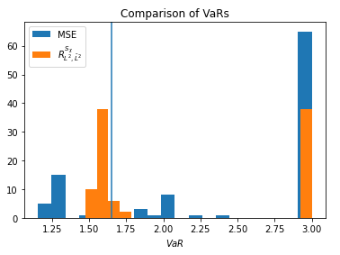

This can be better shown when computing the absolute error between the computed and the true VaR:

In [ ]:
plt.hist(np.array(mse_var) - VaR, bins=20)
plt.hist(np.array(qdml_var) - VaR, bins=20)
plt.xlabel(r"$VaR-VaR_{True}$")
plt.legend(["MSE", r"$R_{L^2, \bar{L}^2}^{S_{\chi}}$"])
plt.title("Comparison of error in VaR")

As can be seen the trained models with $R_{L^2, \bar{L}^2}^{S_{\chi}}$ has lower error than the **MSE** ones:

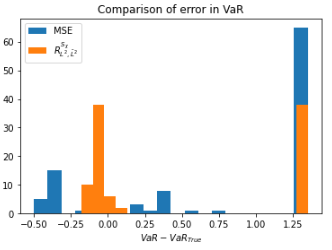